In [1]:
# !pip install --upgrade pip setuptools wheel
# !pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client pandas torch

In [2]:
# conda install -c conda-forge google-api-python-client

In [3]:
#https://drive.google.com/file/d/1k7rNdlcekzCtR1OJ3oTbUsY4k9D5nx22/view?usp=drive_link

In [4]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

from google_auth_oauthlib.flow import InstalledAppFlow
import pandas as pd
import numpy as np
import io

# Define scope for Google Drive API
SCOPES = ['https://www.googleapis.com/auth/drive']

# Authenticate using OAuth
flow = InstalledAppFlow.from_client_secrets_file("/Users/st/Downloads/Client Secret My First Project.json", SCOPES)
creds = flow.run_local_server(port=0)

# Build Google Drive API service
service = build('drive', 'v3', credentials=creds)



Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=19550535075-3dbc6tratna1rb30pmdbsqv269qlrid0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A52231%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=6lA7x53qbXAYdyLe2FPTHDSIxGl9MJ&access_type=offline


In [5]:
# Google Drive File ID (Replace with your actual file ID)
file_id = "1k7rNdlcekzCtR1OJ3oTbUsY4k9D5nx22"

# Request the file from Google Drive
request = service.files().get_media(fileId=file_id)
file_stream = io.BytesIO()
downloader = MediaIoBaseDownload(file_stream, request)

done = False
while not done:
    status, done = downloader.next_chunk()

# Load .npz file into memory
file_stream.seek(0)
data = np.load(file_stream)

# Display available arrays inside .npz
print("Keys inside .npz file:", data.files)

# Example: Access a specific array (replace 'arr_0' with the actual key)
array1 = data['arr_0']
print("Array 1 Shape:", array1.shape)

Keys inside .npz file: ['arr_0', 'arr_1']
Array 1 Shape: (38015, 52, 52)


In [6]:
array2 = data['arr_1']
print("Array 2 Shape:", array2.shape)

Array 2 Shape: (38015, 8)


In [7]:
X=np.array(array1)
Y=np.array(array2)
print(Y[0:5])

[[1 0 1 0 0 0 1 0]
 [1 0 1 0 0 0 1 0]
 [1 0 1 0 0 0 1 0]
 [1 0 1 0 0 0 1 0]
 [1 0 1 0 0 0 1 0]]


In [8]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, Dataset
import json

In [9]:
#conda install torchvision -c pytorch

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import math

In [11]:
# Convert one-hot labels to a hashable format (string) for stratified sampling
y_str_labels = np.array(["".join(map(str, label)) for label in Y])

# Perform stratified split based on string labels
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=y_str_labels)

print(f"Training Samples: {X_train.shape}, Testing Samples: {X_test.shape}")
#print(X_train)
print(y_train[0:5])

Training Samples: (30412, 52, 52), Testing Samples: (7603, 52, 52)
[[0 0 0 0 0 0 1 0]
 [1 0 1 0 1 0 1 0]
 [1 0 1 0 1 0 1 0]
 [1 0 1 0 1 0 1 0]
 [0 1 1 0 0 0 0 0]]


 In following code, the label has been mapped with numbers (follow pdf to know more, its in sequence)

Convert to pytorch tensors

In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Add channel dimension
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)  # Keep as one-hot encoded
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Final Tensor Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# # Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG16 input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

Final Tensor Shapes:
X_train: torch.Size([30412, 52, 52]) y_train: torch.Size([30412, 8])
X_test: torch.Size([7603, 52, 52]) y_test: torch.Size([7603, 8])


Dataset Class

In [13]:
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image

class My_Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        # Ensure X and y are NumPy arrays
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        if isinstance(y, torch.Tensor):
            y = y.numpy()

        # Ensure X has a channel dimension
        self.images = X.astype(np.float32)  # Shape: (N, 1, 52, 52)

        # Keep labels as multi-label one-hot vectors (Replace NaNs with 0 if needed)
        self.labels = np.nan_to_num(y).astype(np.float32)

        self.transform = transform
        print(f"Dataset initialized with {len(self.images)} samples.")

    def __len__(self):
        return len(self.images)  # Correct dataset length

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]  # Multi-label format (not single class index)
        
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)  

        # Ensure image has 3 channels
        image = image.convert("RGB")  # Convert grayscale to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, torch.tensor(label, dtype=torch.float32)

Creating Training and Testing Dataset

In [14]:
# Create dataset instances
train_dataset = My_Dataset(X_train, y_train, transform=transform)
test_dataset = My_Dataset(X_test, y_test , transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Test Loader: {len(test_loader)} batches")

for images, labels in train_loader:
    print("Batch Shape:", images.shape)  # Should be [BATCH_SIZE, 3, 224, 224]
    break

Dataset initialized with 30412 samples.
Dataset initialized with 7603 samples.
Train Loader: 951 batches
Test Loader: 238 batches
Batch Shape: torch.Size([32, 3, 224, 224])


Visualising the dataset


In [15]:
# Define defect class names (assuming 8 types)
defect_classes = [
    "Center", "Donut", "Edge_Local", "Edge_Ring", 
    "Local", "Near_Full", "Scratch", "Random"]

# Function to convert one-hot encoding to human-readable labels
def decode_labels(one_hot_vector):
    return [defect_classes[i] for i, val in enumerate(one_hot_vector) if val == 1]

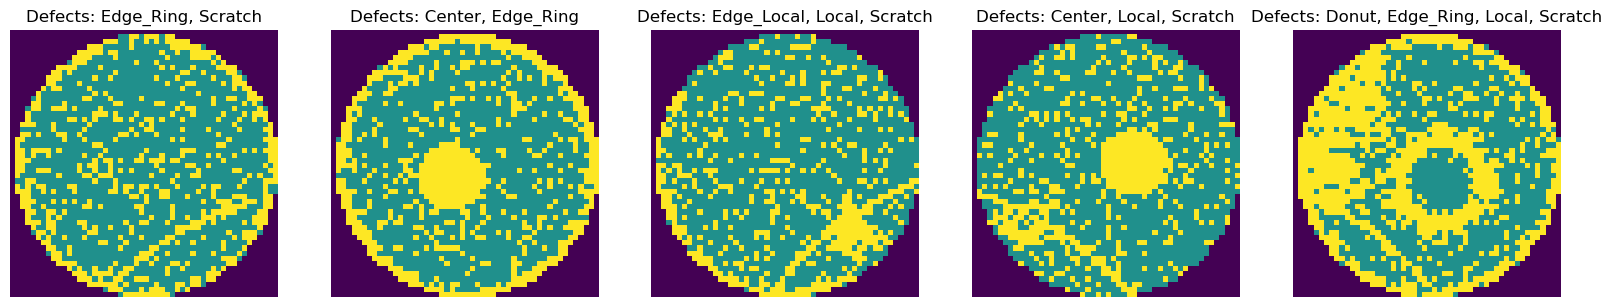

In [16]:
# Function to visualize wafer maps
def visualize_wafer_samples(X, y, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        idx = np.random.randint(len(X))  # Get a random index
        image = X[idx].squeeze().numpy()  # Extract the image correctly
        label = y[idx].numpy()  # Extract the label correctly
        
        # Decode one-hot labels to human-readable defect names
        label_str = ", ".join(decode_labels(label))

        axes[i].imshow(image)
        axes[i].set_title(f"Defects: {label_str}")
        axes[i].axis("off")

    plt.show()

# Display 5 training samples
visualize_wafer_samples(X_train, y_train)

In [17]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_class=8):
        self.num_class = num_class
        super(VGG16Classifier, self).__init__()
        
        #Fully Connected Classifier (self.classifier)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_class), )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        loss = 0
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [18]:
class MultiLabelVGG16(nn.Module):
    def __init__(self, num_classes=8):
        super(MultiLabelVGG16, self).__init__()
        model = models.vgg16(pretrained=False)
        model.load_state_dict(torch.load('/Users/st/Projects/CDADA/VGG16 Model.pth'))
        self.feature_extractor = model.features  # Load Pretrained VGG16
        self.feature_extractor.classifier = nn.Identity()  # Remove default classifier
        self.classifier = VGG16Classifier(num_class=num_classes)  # Use your classifier

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten before classifier
        x = self.classifier(x)  # Classifier outputs raw logits
        return x  # No softmax, will use BCEWithLogitsLoss()

In [ ]:
# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize model
num_classes = 8  # Update based on your dataset
net = MultiLabelVGG16(num_classes=num_classes).to(device)

# Define Loss and Optimizer
loss_function = nn.BCEWithLogitsLoss()  # Multi-label classification loss
optimizer = optim.Adam(net.parameters(), lr=3e-5)  # Adam optimizer

/Users/st/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/st/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# epochs = 40  # Number of epochs
# best_acc = 0.0  # Track best validation accuracy

# for epoch in range(epochs):
#     net.train()  # Set model to training mode
#     total_loss = 0
#     train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)  # Progress bar

#     for step, data in enumerate(train_bar):
#         images, labels = data
#         optimizer.zero_grad()

#         images = images.float().to(device)
#         labels = labels.float().to(device)

#         outputs = net(images).to(torch.float32)  # Forward pass
#         loss = loss_function(outputs, labels)  # Compute loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update model

#         total_loss += loss.item()
#         train_bar.desc = f"train epoch[{epoch+1}/{epochs}] loss:{loss:.3f}"

# print("Finished Training")

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import sys

epochs = 40  # Number of epochs
best_acc = 0.0  # Track best validation accuracy

for epoch in range(epochs):
    net.train()  # Set model to training mode
    total_loss = 0
    correct_train = 0
    total_train_samples = 0
    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)  # Progress bar

    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()

        images = images.float().to(device)
        labels = labels.float().to(device)

        outputs = net(images).to(torch.float32)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model

        total_loss += loss.item()

        # **Compute Training Accuracy**
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary
        correct_train += (predicted_labels == labels).all(dim=1).sum().item()  # Count fully correct samples
        total_train_samples += labels.size(0)

        train_bar.desc = f"train epoch[{epoch+1}/{epochs}] loss:{loss:.3f}"

    train_acc = correct_train / total_train_samples
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")

    # **Validation Phase**
    net.eval()
    correct_val = 0
    total_val_samples = 0
    total_val_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)

            outputs = net(images).to(torch.float32)
            loss = loss_function(outputs, labels)

            total_val_loss += loss.item()

            # **Compute Validation Accuracy**
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted_labels == labels).all(dim=1).sum().item()  # Count fully correct samples
            total_val_samples += labels.size(0)

    val_acc = correct_val / total_val_samples
    print(f"Epoch [{epoch+1}/{epochs}] - Val Loss: {total_val_loss/len(test_loader):.4f} | Val Acc: {val_acc:.4f}")

    # **Update Best Accuracy**
    if val_acc > best_acc:
        best_acc = val_acc
        print(f"✅ New Best Accuracy: {best_acc:.4f}")

print(f"Finished Training - Best Validation Accuracy: {best_acc:.4f}")

In [ ]:
def visualize_predictions(model, dataloader, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i >= num_samples:
                break

            images = images.float().to(device)
            labels = labels.numpy()

            outputs = model(images).cpu()
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float().numpy()

            image = images[0].cpu().squeeze().numpy()
            print(f"True Labels: {labels[0]}, Predicted: {predicted_labels[0]}")

# Visualize some predictions
visualize_predictions(net, test_loader)